In [41]:
import importlib
import func
importlib.reload(func)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
pd.options.display.max_rows = 100
%matplotlib inline
importlib.reload(func)
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

In [3]:
df_101_tier = pd.read_excel("data/df_tier_gisc.xlsx")
# df_101_tier = df_101_tier.set_index("RTN")

In [37]:
df_101_tier.shape

(9591, 397)

In [5]:
df_101_tier.head()

A1  A2  A2A  A2B  A3  A3A  A3B  A3C  A3D  B6 ...   CVOC  ERROR  \
1-0017194   1   0    0    0   1    1    0    0    0   0 ...      0      0   
1-0017315   1   1    1    0   0    0    0    0    0   0 ...      0      0   
1-0017321   1   1    1    0   0    0    0    0    0   0 ...      0      0   
1-0017322   1   0    0    0   1    1    0    0    0   0 ...      0      0   
1-0017326   1   1    1    0   0    0    0    0    0   1 ...      0      0   

           METAL  O/HM  OTHER  PAH  PCB  PETROLEUM  UNKNOWN  VOC  
1-0017194      0     0      0    0    0          1        0    0  
1-0017315      0     0      0    0    0          1        0    0  
1-0017321      0     0      0    0    0          1        0    0  
1-0017322      1     0      0    0    0          0        0    0  
1-0017326      0     0      0    0    0          1        0    0  

[5 rows x 397 columns]

## 1. Use all features and Oversampling

In [6]:
X = df_101_tier.drop("Tier1D", axis=1)
y = df_101_tier["Tier1D"]
# y = df_101_tier["IRA"]

In [7]:
y.groupby(y).count()

Tier1D
Non-Tier1D    7995
Tier1D        1596
Name: Tier1D, dtype: int64

### 1.1 Use Random Forest to extract features

In [44]:
# Use random forest to extract useful features
# Use all the data
rfmodel = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1)
rfmodel.fit(X, y)
feat_import = pd.DataFrame({"Feature": X.columns, "Importance": rfmodel.feature_importances_})\
        .sort_values("Importance", ascending=False)
feat20 = feat_import.iloc[:20, 0].tolist()

In [45]:
feat20

['D10A',
 'D6A',
 'H3',
 'H13AVOLUME',
 'F12',
 'D9E',
 'G4',
 'D10J',
 'A1',
 'D4K',
 'PETROLEUM',
 'B6',
 'METAL',
 'C6H',
 'C6E',
 'D8A',
 'D4M',
 'H16',
 'D9L',
 'CVOC']

### 1.2 Use all features to model

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, feat20[:15]], 
                                                    y, 
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=1634)
labels = ["Tier1D", "Non-Tier1D"]

In [47]:
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print(X_train.shape)
print(Counter(y_train).items())
print(X_train.shape)
print("Training size: %r" %X_train.shape[0])
print("Test size: %r" %X_test.shape[0])

(11992, 15)
dict_items([('Non-Tier1D', 5996), ('Tier1D', 5996)])
(11992, 15)
Training size: 11992
Test size: 2398


Normalized confusion matrix
[[ 0.68421053  0.31578947]
 [ 0.39869935  0.60130065]]
             precision    recall  f1-score   support

     Tier1D       0.26      0.68      0.37       399
 Non-Tier1D       0.91      0.60      0.72      1999

avg / total       0.80      0.62      0.66      2398



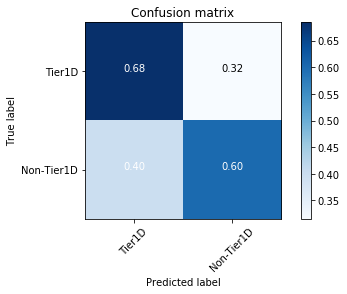

In [42]:
ab = AdaBoostClassifier(learning_rate=0.05, n_estimators=500)
ab.fit(X_train, y_train)
y_predict = ab.predict(X_test)
func.plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=labels), classes=labels)
print(classification_report(y_test, y_predict, labels=labels, target_names=labels))

Confusion matrix, without normalization
[[ 232  167]
 [ 517 1482]]
             precision    recall  f1-score   support

     Tier1D       0.31      0.58      0.40       399
 Non-Tier1D       0.90      0.74      0.81      1999

avg / total       0.80      0.71      0.74      2398



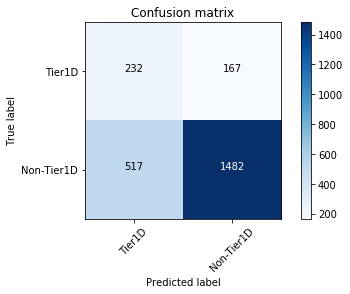

In [42]:
rf = RandomForestClassifier(max_depth=3, n_estimators=500, max_features=0.2, n_jobs=-1)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
func.plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=labels), classes=labels)
print(classification_report(y_test, y_predict, labels=labels, target_names=labels))

In [43]:
svc = LinearSVC(dual=False, C=0.01, penalty='l1')
svc.fit(X_train, y_train)
y_predict = svc.predict(X_test)
func.plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=labels), classes=labels)
print(classification_report(y_test, y_predict, labels=labels, target_names=labels))

Confusion matrix, without normalization
[[ 271  128]
 [ 678 1321]]
             precision    recall  f1-score   support

     Tier1D       0.29      0.68      0.40       399
 Non-Tier1D       0.91      0.66      0.77      1999

avg / total       0.81      0.66      0.71      2398



Confusion matrix, without normalization
[[ 233  166]
 [ 508 1491]]
             precision    recall  f1-score   support

     Tier1D       0.31      0.58      0.41       399
 Non-Tier1D       0.90      0.75      0.82      1999

avg / total       0.80      0.72      0.75      2398



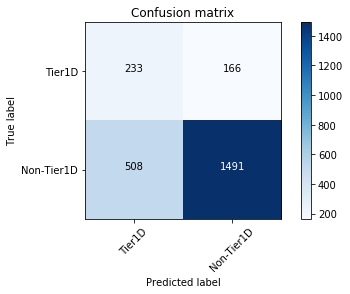

In [ ]:
# {'C': 0.1, 'dual': False, 'penalty': 'l2'}
lg = LogisticRegression(C=0.1, dual=False, )
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
func.plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=labels), classes=labels)
print(classification_report(y_test, y_predict, labels=labels, target_names=labels))

In [48]:
# {'C': 0.1, 'dual': False, 'penalty': 'l2'}
rc = RidgeClassifier(alpha=100)
rc.fit(X_train, y_train)
y_predict = rc.predict(X_test)
func.plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=labels), classes=labels)
print(classification_report(y_test, y_predict, labels=labels, target_names=labels))

Normalized confusion matrix
[[ 0.80451128  0.19548872]
 [ 0.45872936  0.54127064]]
             precision    recall  f1-score   support

     Tier1D       0.26      0.80      0.39       399
 Non-Tier1D       0.93      0.54      0.69      1999

avg / total       0.82      0.59      0.64      2398



In [29]:
X.shape

(10888, 154)

In [30]:
Xs.head()

A1   B6  C6H  C6L  D10A  D10I  D4M  D6A  D9G  D9L    ...      H13AOFFSITE  \
0  1.0  0.0  1.0  1.0   0.0   1.0  0.0  0.0  0.0  0.0    ...              1.0   
1  1.0  0.0  0.0  0.0   0.0   1.0  0.0  0.0  1.0  0.0    ...              1.0   
2  0.0  0.0  0.0  1.0   0.0   0.0  0.0  0.0  0.0  0.0    ...              0.0   
3  0.0  1.0  0.0  1.0   0.0   1.0  0.0  0.0  0.0  0.0    ...              1.0   
4  1.0  0.0  0.0  1.0   0.0   1.0  0.0  0.0  0.0  0.0    ...              1.0   

   H13AVOLUME  H13BVOLUME  H13CVOLUME  H16   H3  LUST_ELIGIBLE_NO  \
0        25.0         0.0         0.0  0.0  0.0               1.0   
1       100.0         0.0         0.0  0.0  0.0               0.0   
2         0.0         0.0         0.0  0.0  0.0               1.0   
3       250.0         0.0         0.0  0.0  0.0               0.0   
4       250.0         0.0         0.0  0.0  0.0               0.0   

   LUST_ELIGIBLE_UNKNOWN  STAFF_UNASSIGNED  PETROLEUM  
0                    0.0               0.0        1.0  
1                    1.0               0.0        1.0  
2                    0.0               0.0        1.0  
3                    0.0               0.0        1.0  
4                    1.0               0.0        1.0  

[5 rows x 26 columns]

### PCA

In [17]:
pca = PCA(n_components=10)
Xpca = pca.fit_transform(X)

In [18]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.76038212,  0.85041021,  0.90658705,  0.93995279,  0.96008573,
        0.97190767,  0.98024974,  0.98487089,  0.98822489,  0.99101516])